# H20 AutoML Kilocalorie Regression

## Abstract
This notebook is a simple example of using H20 AutoML to predict the kilocalories of common foods based on its nutritional composition. 

The model is trained using H20 AutoML and the best model is selected based on the root mean squared error (RMSE) of the test set. 

This research found that the best model to predict the kilocalories 

## Modeling with AutoML 
H2O will speed up some of the basic data processing steps, feature engineering, and model testing so I can focus on determing the best model for this dataset.

In [86]:
# Importing necessary libraries
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [87]:
!pip3 install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [123]:
# Importing necessary libraries
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
import psutil
import random
import logging
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm

## Virtual Machine Configuration

In [89]:
min_mem_size=6 
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

1


In [90]:
port_no=random.randint(5555,55555)
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)    
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:39940..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.4" 2022-07-19; OpenJDK Runtime Environment Temurin-17.0.4+8 (build 17.0.4+8); OpenJDK 64-Bit Server VM Temurin-17.0.4+8 (build 17.0.4+8, mixed mode)
  Starting server from /Users/vraosharma/Desktop/Python/DSEMT/exploratory-data-analysis/venv/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/tmpk92hfimg
  JVM stdout: /var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/tmpk92hfimg/h2o_vraosharma_started_from_python.out
  JVM stderr: /var/folders/36/syxnttfx02z8nxmjh2_llhnr0000gn/T/tmpk92hfimg/h2o_vraosharma_started_from_python.err
  Server is running at http://127.0.0.1:39940
Connecting to H2O server at http://127.0.0.1:39940 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.1
H2O_cluster_version_age:,16 days
H2O_cluster_name:,H2O_from_python_vraosharma_ue6qan
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


## Re-acquainting Ourselves with the Data
This project is a continuation of , so I'll be using the [Food Nutrition Dataset](https://www.kaggle.com/datasets/shrutisaxena/food-nutrition-dataset?resource=download&select=food.csv) (which is based on the USDA's [FoodData Central database](https://fdc.nal.usda.gov/fdc-app.html#/)) used in my Predicting Kilocalories with Linear Regression notebook (check that out first to see the profile of the data). Special thanks to SHRUTI SAXENA for compiling this dataset.

In [91]:
# Addding the dataset from github https://github.com/vraosharma-northeastern/exploratory-data-analysis/blob/main/Nutrition%20/food.csv
!wget https://raw.githubusercontent.com/vraosharma-northeastern/exploratory-data-analysis/main/Nutrition%20/food.csv

zsh:1: command not found: wget


In [92]:
# Reading the file into a dataframe and viewing the first few rows
dff = pd.read_csv('food.csv')

In [93]:
dff.head()

,Category,Description,Nutrient Data Bank Number,Data.Alpha Carotene,Data.Ash,Data.Beta Carotene,Data.Beta Cryptoxanthin,Data.Carbohydrate,Data.Cholesterol,Data.Choline,...,Data.Major Minerals.Potassium,Data.Major Minerals.Sodium,Data.Major Minerals.Zinc,Data.Vitamins.Vitamin A - IU,Data.Vitamins.Vitamin A - RAE,Data.Vitamins.Vitamin B12,Data.Vitamins.Vitamin B6,Data.Vitamins.Vitamin C,Data.Vitamins.Vitamin E,Data.Vitamins.Vitamin K
0,BUTTER,"BUTTER,WITH SALT",1001,0,2.11,158,0,0.06,215,19,...,24,576,0.09,2499,684,0.17,0.003,0.0,2.32,7.0
1,BUTTER,"BUTTER,WHIPPED,WITH SALT",1002,0,2.11,158,0,0.06,219,19,...,26,827,0.05,2499,684,0.13,0.003,0.0,2.32,7.0
2,BUTTER OIL,"BUTTER OIL,ANHYDROUS",1003,0,0.00,193,0,0.00,256,22,...,5,2,0.01,3069,840,0.01,0.001,0.0,2.80,8.6
3,CHEESE,"CHEESE,BLUE",1004,0,5.11,74,0,2.34,75,15,...,256,1395,2.66,763,198,1.22,0.166,0.0,0.25,2.4
4,CHEESE,"CHEESE,BRICK",1005,0,3.18,76,0,2.79,94,15,...,136,560,2.60,1080,292,1.26,0.065,0.0,0.26,2.5


As we can see above, each row represents a food type; the *Description* column contains a breakdown of the few ingredients that comprise the dish or food as well as details of how it was prepared. Some foods have multiple entries in the dataset because they were prepared in different ways, e.g. raw, cooked, fried, etc. Additionally, some foods have multiple entries because they were prepared with different ingredients, e.g. with or without salt, with or without sugar, etc.

As we did in the last notebook, we will do some preprocessing to make this dataset make more sense. We will start by removing the redundant 'Data.' tag from the column names.

In [94]:
#Reading the file into a dataframe and viewing the first few rows
dff = pd.read_csv('food.csv')

# Loop through columns and remove redundant 'Data.' tag from column names
for col in dff.columns:
    new_col = col.replace('Data.', '')  # Remove 'Data.' from the column name
    dff.rename(columns={col: new_col}, inplace=True)  # Rename the column name in dataframe

# Show the first few rows of the dataset
dff.describe()

,Nutrient Data Bank Number,Alpha Carotene,Ash,Beta Carotene,Beta Cryptoxanthin,Carbohydrate,Cholesterol,Choline,Fiber,Kilocalories,...,Major Minerals.Potassium,Major Minerals.Sodium,Major Minerals.Zinc,Vitamins.Vitamin A - IU,Vitamins.Vitamin A - RAE,Vitamins.Vitamin B12,Vitamins.Vitamin B6,Vitamins.Vitamin C,Vitamins.Vitamin E,Vitamins.Vitamin K
count,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,...,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000
mean,14116.443680,21.210711,1.852459,159.043437,8.776744,21.785381,37.162822,20.673546,1.993147,219.655875,...,268.348172,331.590719,1.875125,767.568191,99.437070,1.172903,0.269547,9.075651,0.842837,9.448604
std,8767.416214,269.714183,2.993228,1126.285026,154.184860,27.123491,119.738438,45.481990,4.292873,171.668713,...,404.916220,977.046544,4.193682,3871.307652,761.653061,4.512816,0.565116,63.443284,4.169756,66.067619
min,1001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8121.000000,0.000000,0.830000,0.000000,0.000000,0.490000,0.000000,0.000000,0.000000,82.000000,...,103.000000,31.000000,0.190000,0.000000,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000
50%,12539.000000,0.000000,1.240000,0.000000,0.000000,9.290000,2.000000,0.000000,0.300000,181.000000,...,210.000000,86.000000,0.770000,33.000000,0.000000,0.010000,0.110000,0.000000,0.050000,0.000000
75%,18424.000000,0.000000,2.200000,1.000000,0.000000,30.590000,60.000000,20.000000,2.300000,331.000000,...,328.000000,428.000000,2.460000,280.000000,24.000000,0.830000,0.330000,3.500000,0.390000,1.700000
max,93600.000000,14251.000000,99.800000,42891.000000,7923.000000,100.000000,3100.000000,1388.000000,79.000000,902.000000,...,16500.000000,38758.000000,181.610000,100000.000000,30000.000000,98.890000,12.000000,2400.000000,149.400000,1714.500000


Because *2nd Household Weight* and *1st Household Weight* are the same measure expressed in different units and this column has more nulls, we will drop *2nd Household Weight* and it's corresponding *Household Weights.2nd Household Weight Description* below.

Also, because Household Weight Description doesn't really tell us anything that the *Household Weights.1st Household Weight* already containes, we will drop *Household Weights.1st Household Weight Description* as well.

Furthermore, all foods should have a Weight (g) greater than 0. We will remove all rows where the Weight (g) is 0.

In [95]:
# Drop 'Household Weight Description' columns
dff.drop(['Household Weights.2nd Household Weight Description', 'Household Weights.2nd Household Weight','Household Weights.1st Household Weight Description'], axis=1, inplace=True)

# Drop rows where Household Weights.1st Household Weight is 0
dff = dff[dff['Household Weights.1st Household Weight'] != 0]

We will also drop *Vitamin A - IU* because it is redundant to *Vitamin A - RAE* and the [NIH](https://ods.od.nih.gov/factsheets/VitaminA-HealthProfessional/#:~:text=The%20units%20of%20measurement%20for,beta%2Dcarotene%20%3D%200.3%20mcg%20RAE) recommends using *Vitamin A - RAE* to measure Vitamin A intake.

In [96]:
# Drop *Vitamin A - IU* because it is redundant with *Vitamin A - RAE*
dff.drop(['Vitamins.Vitamin A - IU'], axis=1, inplace=True)

Looking at the means, std. deviations, mins, and maxes, of each of our fields we can see that our data needs to be evaluated column by column to determine if each field makes sense. At face value, a mean of 21.8 for Carbohydrates and 37.2 for Cholesterol seems off, but we need to consider the units of each column. 

Of course, we will treat the Data Bank Number as a surrogate key and disregard its distribution. Similarly, Category and Description are categorical variables and we will them in our unit analysis.

Documentation for the dataset is a bit weak. For example, though the first few attributes have clearly defined units in Kaggle, the units for the remaining numeric attributes are not mentioned. Using the source of the data, the USDA FoodData Central, we can compare the values in our dataset to the source of truth and assume the units for each column. To make this simple, we will take the dataset's first entry, Butter [1001](https://fdc.nal.usda.gov/fdc-app.html#/food-details/790508/nutrients). We will assume that the units for each column are the same as the units in the source of truth unless values are off by order(s) of magnitude:

**Attribute: Unit**
1. Ash: g
2. Alpha Carotene: µg
3. Beta Carotene: µg
4. Beta Cryptoxanthin: µg
5. Carbohydrate: g
6. Cholesterol: mg
7. Choline: mg
8. Fat.Monosaturated Fat: g
9. Fat.Polysaturated Fat: g
10. Fat.Saturated Fat: g
11. Fat.Total Lipid: g
12. Fiber: g
13. Household Weights.1st Household Weight: g
14. Kilocalories: kcal
15. Lutein and Zeaxanthin: µg
16. Lycopene: µg
17. Major Minerals.Calcium: mg
18. Major Minerals.Copper: mg
19. Major Minerals.Iron: mg
20. Major Minerals.Magnesium: mg
21. Major Minerals.Phosphorus: mg
22. Major Minerals.Potassium: mg
23. Major Minerals.Sodium: mg
24. Major Minerals.Zinc: mg
25. Manganese: mg
26. Niacin: mg
27. Pantothenic Acid: mg
28. Protein: g
29. Refuse Percentage: % by volume
30. Retinol: µg
31. Riboflavin: mg
32. Selenium: µg
33. Sugar Total: g
34. Thiamin: mg
35. Vitamins.Vitamin A - RAE: µg
36. Vitamins.Vitamin B12: µg
37. Vitamins.Vitamin B6: µg
38. Vitamins.Vitamin C: µg
39. Vitamins.Vitamin E: mg
40. Vitamins.Vitamin K: µg
41. Water: g

Taking a look at the data again, everything seems to make sense. I find it a little strange that the Carbohydrate standard deviation is so high, but that could be because variety of foods in the dataset.

As a final note, I will not be translating categorical data found in the *Categgory* column into a set of dummy variables because categorization is arbitrary. For example, the column contains a few entries that are not necessarily food types, e.g. 'Spices and Herbs', 'no category', etc. and occassionally foods of the same type are split into categories by brand e.g. 'Soup', 'Campbell's Soup'. I could clean this up by introducing a new roll-up category, but this is beyond the scope of this project.

To practice working with dummy variables, however, I will remove the *Vitamins.Vitamin B12* column because, as we can see below, it has the lowest correlation with Kilocalories of all the Vitamins and add a dummy variable for the the column. 

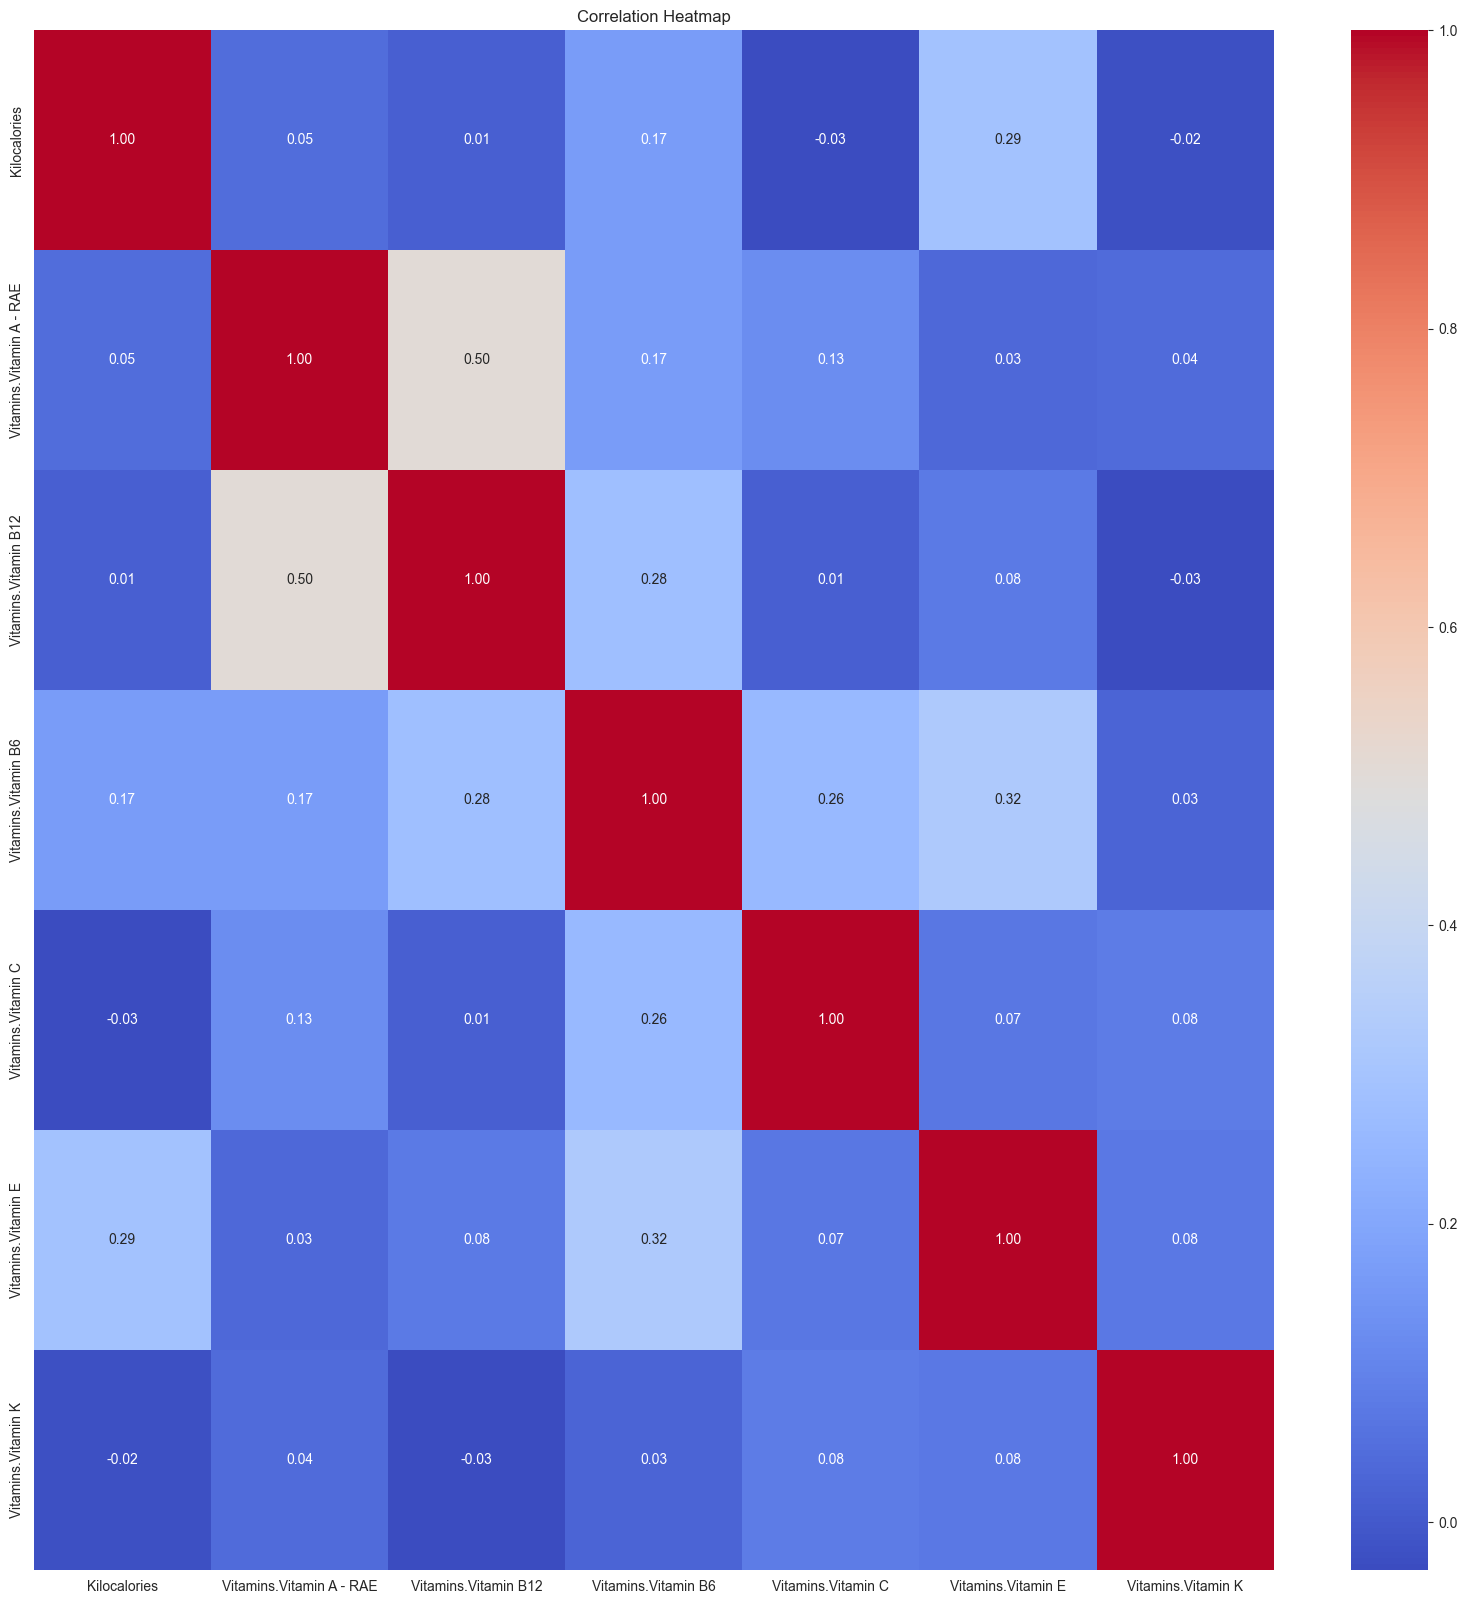

In [97]:
# Create a copy of the dataset
df_fs_correlation = dff.copy()

# Only keep the columns where column name like 'Kilocalories' or 'Vitamins.x'
df_fs_correlation = df_fs_correlation.filter(regex='Kilocalories|Vitamins.*')

# Create a correlation matrix of all independent variables
corr_matrix = df_fs_correlation.corr()

# Create a heatmap of all independent variables
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


In [98]:
# Create a dummy column called 'Vitamins.Vitamin B12' that is 1 if Vitamin B12 is present and 0 if it is not
dff['Vitamins.Vitamin B12 Present'] = np.where(dff['Vitamins.Vitamin B12'] > 0, 1, 0)

# Drop the 'Vitamins.Vitamin B12' column
dff.drop(['Vitamins.Vitamin B12'], axis=1, inplace=True)

Finally, let's drop the *Data Bank Number* column because it is a surrogate key and the *Category* and *Description* columns because they are categorical variables that we are not going to be using in our model.

In [99]:
# Drop the 'Data Bank Number', 'Category', and 'Description' columns
dff.drop(['Category', 'Description'], axis=1, inplace=True)

## Creating Training and Test Sets and Generating Models with H2O
Let's load the pre-processed data into an H2O frame and split it up into training and test sets. We will use 80% of the data for training and 20% for testing.

Remember, our predictors will be all the columns except for *Kilocalories* and our response variable will be *Kilocalories*.

In [100]:
# Show initial shape of dataframe
print('Initial shape of dataframe:', dff.shape)

Initial shape of dataframe: (6943, 42)


In [101]:
# Convert the dataframe to an H2OFrame
df = h2o.H2OFrame(dff)

# Splitting the data into training and test sets
pct_rows=0.80
df_train, df_test = df.split_frame([pct_rows])

# Show shape of training set and test set
print('Training set shape:', df_train.shape)
print('Test set shape:', df_test.shape)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training set shape: (5512, 42)
Test set shape: (1431, 42)


In [102]:
# Setting the predictor and response variables
y = 'Kilocalories'
X = list(df.columns)
X.remove(y)

# Print predictors
print('Predictors:', X)

# Print response variable
print('Response:', y)

Predictors: ['Nutrient Data Bank Number', 'Alpha Carotene', 'Ash', 'Beta Carotene', 'Beta Cryptoxanthin', 'Carbohydrate', 'Cholesterol', 'Choline', 'Fiber', 'Lutein and Zeaxanthin', 'Lycopene', 'Manganese', 'Niacin', 'Pantothenic Acid', 'Protein', 'Refuse Percentage', 'Retinol', 'Riboflavin', 'Selenium', 'Sugar Total', 'Thiamin', 'Water', 'Fat.Monosaturated Fat', 'Fat.Polysaturated Fat', 'Fat.Saturated Fat', 'Fat.Total Lipid', 'Household Weights.1st Household Weight', 'Major Minerals.Calcium', 'Major Minerals.Copper', 'Major Minerals.Iron', 'Major Minerals.Magnesium', 'Major Minerals.Phosphorus', 'Major Minerals.Potassium', 'Major Minerals.Sodium', 'Major Minerals.Zinc', 'Vitamins.Vitamin A - RAE', 'Vitamins.Vitamin B6', 'Vitamins.Vitamin C', 'Vitamins.Vitamin E', 'Vitamins.Vitamin K', 'Vitamins.Vitamin B12 Present']
Response: Kilocalories


## Relationships Between Predictors and Response
Let's take a look at the relationship between the predictors and the response variable. We will do this by performing an OLS on the data and looking at the p-values of the coefficients.

In [126]:
# Compute the OLS
ols = sm.OLS(df_train[y].as_data_frame(), df_train[X].as_data_frame()).fit()

# Print the summary
print(ols.summary())

                                 OLS Regression Results                                
Dep. Variable:           Kilocalories   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                          4.159e+04
Date:                Wed, 01 Nov 2023   Prob (F-statistic):                        0.00
Time:                        13:33:39   Log-Likelihood:                         -23075.
No. Observations:                5512   AIC:                                  4.623e+04
Df Residuals:                    5471   BIC:                                  4.650e+04
Df Model:                          41                                                  
Covariance Type:            nonrobust                                                  
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------

**Is the relationship significant?** We can see that the p-value is less than 0.05 for just a few predictors, where Fat Total Lipids has the largest positive relationship between to the response with a coefficient of 8.8. The following predictors have a significant relationship with the response as well:
2. Protein : 4.27
3. Carbohydrate : 3.99
4. Minerals.Copper : -3.52
5. Fiber : -1.64
6. Vitamin B6 : -1.48 
7. Zinc : 0.14
8. Water : 0.04
9. Selenium : 0.014
10. Magnesium : -0.05
11. Beta Cryptoxanthin : -0.005
12. Household Weights.1st Household Weight : -0.002
13. Phosphorus : -.001

A few of these predictors are a bit suspect; for example, I'd expect Water to have a much higher coefficient than copper of Zinc.

In [131]:
# Compute the VIF Scores for each predictor
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe to store the VIF Scores
vif_data = pd.DataFrame()

# Setting the predictor and response variables for the VIF Scores
y = 'Kilocalories'
X = list(dff.columns)
X.remove(y)
MultiCollinearity = dff[X]

# Add the column names to the dataframe
vif_data["feature"] = MultiCollinearity.columns

# Compute the VIF Scores for each predictor in dff
vif_data["VIF"] = [variance_inflation_factor(MultiCollinearity.values, i) for i in range(len(MultiCollinearity.columns))]

# Print the VIF Scores
print(vif_data)

                                   feature        VIF
0                Nutrient Data Bank Number   4.374266
1                           Alpha Carotene   2.224512
2                                      Ash  14.197956
3                            Beta Carotene   5.277072
4                       Beta Cryptoxanthin   1.354847
5                             Carbohydrate   4.688146
6                              Cholesterol   1.425858
7                                  Choline   1.675952
8                                    Fiber   2.427328
9                    Lutein and Zeaxanthin   2.142812
10                                Lycopene   1.026183
11                               Manganese   1.248941
12                                  Niacin   6.854982
13                        Pantothenic Acid   2.027459
14                                 Protein   5.283523
15                       Refuse Percentage   1.445294
16                                 Retinol  97.848473
17                          

**Is there any multicollinearity in the model? Are predictor variables independent of all the other predictor variables?** We can see that the VIF scores are very high for a few predictors. Taking a closer look, we can see logical multi-collinearity between the following high-scoring predictors:
* Fat Total Lipids and other Fat predictors
* Retinol and Vitamin A predictors

This makes total sense since Total Fat is the sum of the other Fat predictors and Retinol is a form of Vitamin A.

### AutoML Execution with H2O
This is the easy part - let's use H2O's AutoML to generate the 20 models for this dataset.

Using the Virtual Machine config defined above, I will train the models on the training set and evaluate them on the test set.

In [103]:
# Set up AutoML
aml = H2OAutoML(seed =1, max_models=20, stopping_metric='RMSE', sort_metric='RMSE',  verbosity='info')

In [104]:
# Pass the data through H20AutoML
aml.train(x=X,y=y,training_frame=df_train)  

AutoML progress: |
11:53:40.299: Project: AutoML_1_20231101_115340
11:53:40.300: 5-fold cross-validation will be used.
11:53:40.300: Setting stopping tolerance adaptively based on the training frame: 0.013469311461009133
11:53:40.301: Build control seed: 1
11:53:40.301: training frame: Frame key: AutoML_1_20231101_115340_training_py_25_sid_b8c7    cols: 42    rows: 5512  chunks: 1    size: 523435  checksum: 6410428406474104479
11:53:40.301: validation frame: NULL
11:53:40.301: leaderboard frame: NULL
11:53:40.301: blending frame: NULL
11:53:40.301: response column: Kilocalories
11:53:40.301: fold column: null
11:53:40.301: weights column: null
11:53:40.307: AutoML: XGBoost is not available; skipping it.
11:53:40.309: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 (2g, 10w)

key,value
Stacking strategy,cross_validation
Number of base models (used / total),12/20
# GBM base models (used / total),6/10
# DRF base models (used / total),2/2
# GLM base models (used / total),1/1
# DeepLearning base models (used / total),3/7
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


We'll ignore this read out for now and come back to this model later.

In [105]:
# View the AutoML Leaderboard
lb = aml.leaderboard

# Print top 10. Show as dataframe so we can see model indices.
lb.head().as_data_frame()

,model_id,rmse,mse,mae,rmsle,mean_residual_deviance
0,StackedEnsemble_AllModels_1_AutoML_1_20231101_...,11.305424,127.812613,5.293631,0.113137,127.812613
1,StackedEnsemble_BestOfFamily_1_AutoML_1_202311...,11.356041,128.959664,5.313807,0.105254,128.959664
2,GBM_grid_1_AutoML_1_20231101_115340_model_5,12.012237,144.293842,5.651076,0.105841,144.293842
3,GBM_3_AutoML_1_20231101_115340,12.289671,151.036002,6.147866,0.113085,151.036002
4,GBM_2_AutoML_1_20231101_115340,12.432013,154.554942,6.500717,0.128761,154.554942
5,GBM_4_AutoML_1_20231101_115340,12.526436,156.911594,6.004384,NaN,156.911594
6,GBM_5_AutoML_1_20231101_115340,12.746084,162.462657,6.677152,0.129829,162.462657
7,GBM_grid_1_AutoML_1_20231101_115340_model_2,12.818013,164.301456,7.045559,0.151952,164.301456
8,DRF_1_AutoML_1_20231101_115340,13.191613,174.018658,6.564625,0.120244,174.018658
9,XRT_1_AutoML_1_20231101_115340,13.258293,175.782337,6.607413,0.117019,175.782337


Above we can see the leaderboard of the models that were generated by H2O AutoML. To cut down on the scope, I'll be focusing on 2: 
* Model 0: StackedEnsemble_AllModels_1_AutoML_1_20231101_115340
* Model 2: GBM_grid_1_AutoML_1_20231101_115340_model_5

## Model Evaluation and Tweaking
This next section is going to be a bit long as I break down each model down to its components and analyze its parameters and predictions. Starting with the best performing model of the set based on RMSE, "StackedEnsemble_AllModels_1_AutoML_1_20231101_115340", I'll answer to following guiding questions for both models:

* **Are any model assumptions violated?**
* **Does the model make sense?**
* **Which hyperparameters are important?**

Then, I will use following techniques to tweak the model and see if I can answer these questions:
* **Does excluding insignificant variables from the model help RMSE?**
* **Does Ridge regularization help reduce RSME?**

### Model 0: StackedEnsemble_AllModels_1_AutoML_1_20231101_115340

In [119]:
# Get the best model
model0 = h2o.get_model(lb[0,'model_id'])
print ('----------------TESTING--------------------')
# Show the results of the best model on the test set
print(model0.model_performance(df_test))
print ('')
print ('')
print ('----------------TRAINING AND CROSS-VALIDATION--------------------')
print(model0)

----------------TESTING--------------------
ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 130.25537034815733
RMSE: 11.412947487312703
MAE: 5.08378776327731
RMSLE: 0.1658164448974744
Mean Residual Deviance: 130.25537034815733
R^2: 0.995466835228782
Null degrees of freedom: 1430
Residual degrees of freedom: 1418
Null deviance: 41265413.14868266
Residual deviance: 186395.43496821314
AIC: 11057.252161477301


----------------TRAINING AND CROSS-VALIDATION--------------------
Model Details
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_1_20231101_115340


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       12/20
# GBM base models (used / total)           6/10
# DRF base models (used / total)           2/2
# GLM base model

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

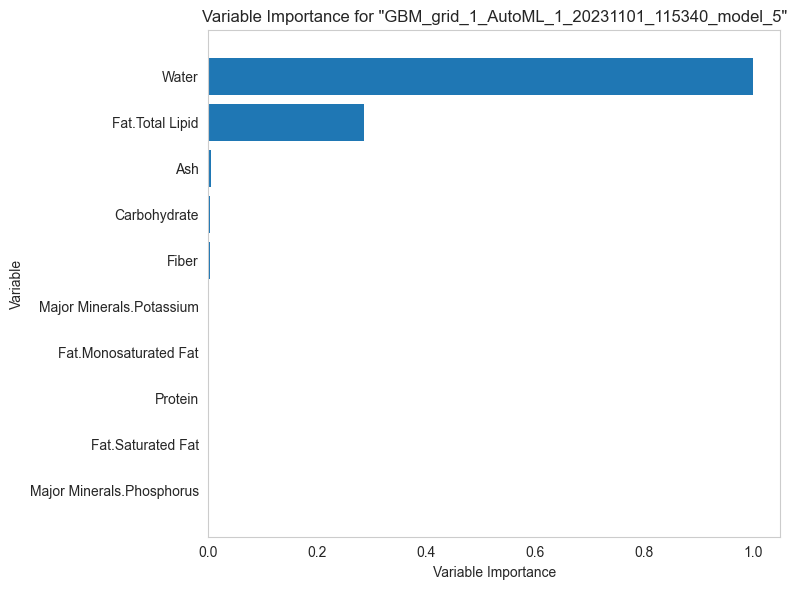

In [120]:
explain_model = aml.explain(frame = df_test, figsize = (8,6),include_explanations=['varimp'])

* **Are any model assumptions violated?**
* **Does the model make sense?**
* **Which hyperparameters are important?**

### Model 2: GBM_grid_1_AutoML_1_20231101_115340_model_5

In [121]:
# Get the model
model2 = h2o.get_model(lb[2,'model_id'])
print ('----------------TESTING--------------------')
# Show the results of the best model on the test set
print(model2.model_performance(df_test))
print ('')
print ('')
print ('----------------TRAINING AND CROSS-VALIDATION--------------------')
print(model2)

----------------TESTING--------------------
ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 157.57862907035815
RMSE: 12.553032664275122
MAE: 5.36157776150208
RMSLE: 0.15528148703619912
Mean Residual Deviance: 157.57862907035815


----------------TRAINING AND CROSS-VALIDATION--------------------
Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_1_20231101_115340_model_5


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    77                 77                          180576                 13           17           16.6364       22            265           180.662

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 30.052838011809285
R

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

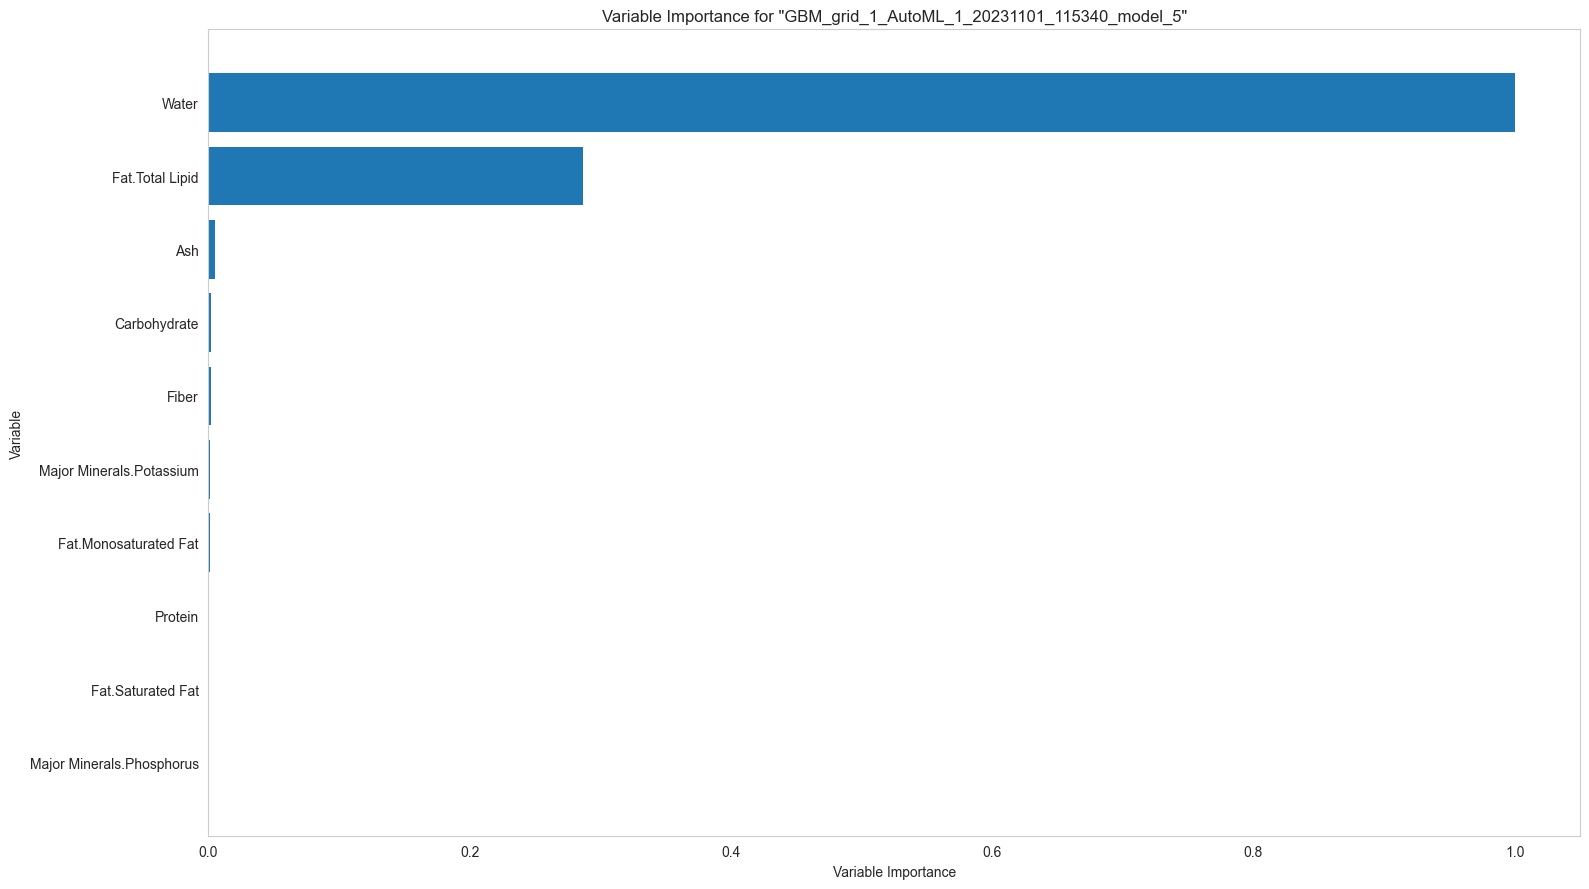

In [145]:
# Plot the variable importance
exm = model2.explain(df_test, include_explanations=['varimp'])

* **What is the rank the most significant predictor variables?**
* **Are any model assumptions violated?**

* **Does the model make sense?**
* **Which hyperparameters are important?**

Then, I will use following techniques to tweak the model and see if I can answer these questions:
* **Does excluding insignificant variables from the model help RMSE?**
* **Does Ridge regularization help reduce RSME?**